In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
%matplotlib inline
folder = '/users/caganze/'

# magnitude error model

We're trying to model the magnitude error as a function of source magnitude and exposure time, with a minimum threshold of $\sigma_{min}$ = 0.003 mag. The model (motivated by the structure of the data) is:

$\sigma = \sigma_{min}(m - m_0)^{\alpha}(t/1000s)^{\beta}$

with a minimum value of $\sigma_{min}$. The fit parameters are $m_0$, $\alpha$ and $\beta$, which we will find iteratively


In [2]:
# fit parameters
sigma_min = 3.e-3
tref = 1000.


In [3]:
# read in file and clean out weird values
pd = pandas.read_csv(folder+'exptimes.csv')
pd = pd[pd['mstar_flag']==1]
pd110 = pd[numpy.isnan(pd['F110'])==False]
pd110 = pd110[pd110['F110_er']>=sigma_min]
pd110 = pd110[pd110['F110_er']<1]
pd140 = pd[numpy.isnan(pd['F140'])==False]
pd140 = pd140[pd140['F140_er']>=sigma_min]
pd140 = pd140[pd140['F140_er']<1]
pd160 = pd[numpy.isnan(pd['F160'])==False]
pd160 = pd160[pd160['F160_er']>=sigma_min]
pd160 = pd160[pd160['F160_er']<1]


Text(0, 0.5, 'F110 error')

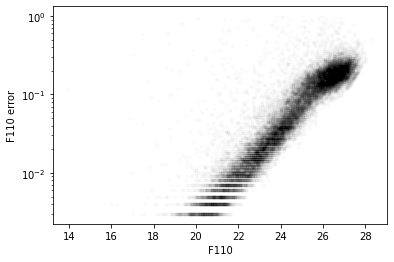

In [4]:
# visualize the measurements
filt = 'F110'
pd = pd110

plt.semilogy(pd[filt],pd[filt+'_er'],'k.',alpha=0.01)
plt.xlabel(filt)
plt.ylabel(filt+' error')

Time coefficient = -0.348+/-0.014
Time coefficient = -0.430+/-0.114
Time coefficient = -0.348+/-0.119


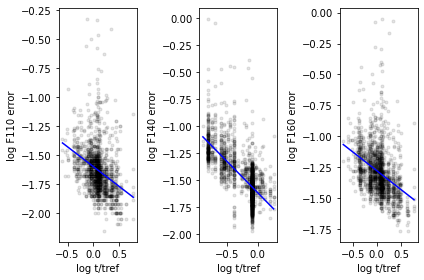

In [5]:
# Evaluate time dependence of series of small range of magnitudes
# use this to get the mean coeffecient for the time exponent
step= 0.5
mags = numpy.arange(22,24.01,step)
coeff=[]

t_coeffs={}
fig, ax=plt.subplots(ncols=3)
for filt, a in zip(['F110', 'F140', 'F160'], ax):
    for m in mags:
        pd=None
        if filt=='F110':
            pd = pd110
        if filt=='F140':
            pd=pd140
        if filt=='F160':
            pd=pd160
        pds = pd[pd[filt]>m]
        pds = pds[pds[filt]<(m+step)]
        mask= numpy.isnan(pds['expt_{}w'.format(filt.lower())].values)
        x = numpy.log10(pds['expt_{}w'.format(filt.lower())]/tref).values[~mask]
        y = numpy.log10(pds[filt+'_er']).values[~mask]

        fit = numpy.polyfit(x,y,1)
        coeff.append(fit[0])
    #print(fit)
        if m == mags[int(0.5*len(mags))]:
            xp = numpy.linspace(numpy.nanmin(x),numpy.nanmax(x),100)
            a.plot(x,y,'k.',alpha=0.1)
            a.plot(xp,numpy.polyval(fit,xp),'b-')
            a.set_xlabel('log t/tref')
            a.set_ylabel('log {} error'.format(filt))
    #plt.semilogy(pd110s['F110'],pd110s['F110_er'],'k.')
    #plt.plot(mags,coeff)
    plt.tight_layout()
    t_coeffs[filt]=[numpy.median(coeff),numpy.std(coeff)]
    print('Time coefficient = {:.3f}+/-{:.3f}'.format(numpy.median(coeff),numpy.std(coeff)))

In [6]:
t_coeffs

{'F110': [-0.3482593410748298, 0.014399485103190963],
 'F140': [-0.4297747738627836, 0.11389384269033631],
 'F160': [-0.3482593410748298, 0.11928211821186432]}

In [7]:
# check the fits make sense
#plt.plot(mags,coeff)
#plt.plot(mags,mags*0+numpy.median(coeff))

In [8]:
unc_coeffs={}

magnitude offset = 19.632, power law coefficient = 0.254
magnitude offset = 19.883, power law coefficient = 0.260
magnitude offset = 18.593, power law coefficient = 0.251


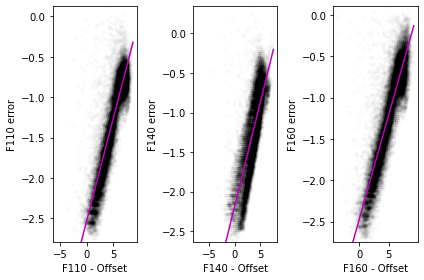

In [17]:
# using this time coefficient, fit the corrected log errors to linear magnitude trend
# iterate to get the zeropoint magnitude

fig, ax=plt.subplots(ncols=3)
for filt, a in zip(['F110', 'F140', 'F160'], ax):
    pd=None
    if filt=='F110':
        pd = pd110
    if filt=='F140':
        pd=pd140
    if filt=='F160':
        pd=pd160
    time_coeff = t_coeffs[filt][0]
    # be sure to put in appropriate one for each filter

    # initial fit without zeropoint
    mask= numpy.logical_or.reduce([numpy.isnan(pd['expt_{}w'.format(filt.lower())].values),
                            numpy.isnan(pd[filt+'_er'].values)])
    x = pd[filt]

    y = numpy.log10(pd[filt+'_er']*(pd['expt_{}w'.format(filt.lower())]/tref)**(-1.*time_coeff))
    xp = numpy.linspace(numpy.nanmin(x),numpy.nanmax(x),100)
    
    #print (x.values, x.values)

    fit = numpy.polyfit(x[~mask],y[~mask],1)
   
    # compute zero point from where log sigma = log sigma_min
    m0 = (numpy.log10(sigma_min)-fit[1])/fit[0]
    
   
    # refit and plot
    x = pd[filt]-m0
    y = numpy.log10(pd[filt+'_er']*(pd['expt_{}w'.format(filt.lower())]/tref)**(time_coeff))
    xp = numpy.linspace(numpy.nanmin(x),numpy.nanmax(x),100)
    
    #print (x.values, y.values)
    mask2= numpy.logical_or.reduce([numpy.isnan(x), numpy.isnan(y)])
    fit = numpy.polyfit(x[~mask2].values,y[~mask2].values,1)
    
    a.plot(x,y,'k.',alpha=0.01)
    a.plot(xp,numpy.polyval(fit,xp),'m-')
    a.set_xlabel('{} - Offset'.format(filt))
    a.set_ylabel(filt+' error')
    a.set_ylim([numpy.nanmin(y),numpy.nanmax(y)])
    print('magnitude offset = {:.3f}, power law coefficient = {:.3f}'.format(m0,fit[0]))
    unc_coeffs[filt]=[m0,time_coeff, fit[0], fit[1]]
    plt.tight_layout()
plt.savefig('/Users/caganze/research/wisps//figures/mag_magerrorfits.pdf')


In [10]:
total_coeffs= unc_coeffs
#for k in ['F110', 'F140', 'F160']:
#    total_coeffs[k]= numpy.concatenate([t_coeffs[k], unc_coeffs[k]])
#unc_coeffs

In [11]:
total_coeffs

{'F110': [19.63217580584945,
  -0.3482593410748298,
  0.2541179554241335,
  -2.531644586328164],
 'F140': [19.883179094204717,
  -0.4297747738627836,
  0.2597682343566297,
  -2.1808887926774103],
 'F160': [18.59282531952515,
  -0.3482593410748298,
  0.25131407450440996,
  -2.4694053803204605]}

In [12]:
output_file='/Users/caganze/research/wisps/db/magnitude_cutoff.pkl'
pol=pandas.read_pickle(output_file)

In [13]:
pol['mag_unc_exp']=total_coeffs

In [14]:
import pickle
with open(output_file, 'wb') as file:
    pickle.dump(pol,file)

In [15]:
pol

{'wisps': {'F110': (poly1d([ 1.35701886, 17.88845524]), 0.5704897212579523),
  'F140': (poly1d([ 0.62779665, 19.39080278]), 0.5662446812084643),
  'F160': (poly1d([ 1.4528292 , 17.14923861]), 1.7686567020674824)},
 'hst3d': {'F110': (None, nan),
  'F140': (poly1d([ 0.08327864, 22.19008988]), 0.27183032908753735),
  'F160': (poly1d([ 0.35644113, 21.30575276]), 0.30745836180468566)},
 'ncutoff': 60,
 'snr_exp': {'F110': array([-0.24719229,  0.14386038,  6.24937269]),
  'F140': array([-0.27870208,  0.19873443,  6.8894099 ]),
  'F160': array([-0.27870208,  0.19873443,  6.8894099 ])},
 'mag_unc_exp': {'F110': [19.63217580584945,
   -0.3482593410748298,
   0.2541179554241335,
   -2.531644586328164],
  'F140': [19.883179094204717,
   -0.4297747738627836,
   0.2597682343566297,
   -2.1808887926774103],
  'F160': [18.59282531952515,
   -0.3482593410748298,
   0.25131407450440996,
   -2.4694053803204605]}}

In [16]:
fcghj

NameError: name 'fcghj' is not defined

In [ ]:
# now evaluate how good of a fit the whole thing is
filt = 'F110'
pd = pd110
time_coeff = -0.35 # be sure to put in appropriate values for each filter
m0 = 19.63
mag_coeff = 0.254

#plt.plot(pd110['expt_f110w'],pd110['F110'],'k.')
x = pd[filt]
y = pd[filt+'_er']
t = pd['expt_{}w'.format(filt.lower())]

# compare without and with time correction (without seems to do better!)
yfit1 = sigma_min*((x-m0)**mag_coeff)
yfit2 = sigma_min*((x-m0)**mag_coeff)*((t/tref)**time_coeff)
sig1 = numpy.std(y-yfit1)
sig2 = numpy.std(y-yfit2)
print(sig1,sig2)

plt.plot(x,y-yfit2,'k.',alpha=0.01)
#plt.semilogy(x,y-yfit1+1,'k.',alpha=0.01)
#plt.plot(x,y-yfit2,'m.',alpha=0.01)
plt.xlabel(filt)
plt.ylabel(filt+' error (observed-predicted)')
plt.ylim([-0.01,0.3])
plt.plot([18,28],[0,0],'k--')